In [1]:
import bayesflow as bf

from model import model, constrain_parameters, constrained_parameter_names, configurator

train = False

/Users/simonkucharsky/projects/bayesflow/amortized-mixture/.venv/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [2]:
def posterior_configurator(input_dict):
    output_dict = configurator(input_dict)
    output_dict["summary_conditions"] = output_dict["observables"]

    return output_dict


In [3]:
amortizer = bf.amortizers.AmortizedPosterior(
    inference_net = bf.networks.InvertibleNetwork(num_params=4, num_coupling_layers=10, coupling_design="spline"),
    summary_net = bf.networks.SequenceNetwork(summary_dim=12, num_conv_layers=4, bidirectional=True),
    summary_loss_fun = "MMD"
)


In [4]:
trainer = bf.trainers.Trainer(amortizer=amortizer, generative_model=model, configurator=posterior_configurator, checkpoint_path="checkpoints/posterior")

INFO:root:Loaded loss history from checkpoints/posterior/history_100.pkl.
INFO:root:Networks loaded from checkpoints/posterior/ckpt-100
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [5]:
%time
if train:
    h = trainer.train_online(epochs=100, iterations_per_epoch=1000, batch_size=64)

CPU times: user 1 µs, sys: 2 µs, total: 3 µs
Wall time: 4.77 µs


In [6]:
df = posterior_configurator(model(1000))

In [7]:
z, _ = amortizer(df)

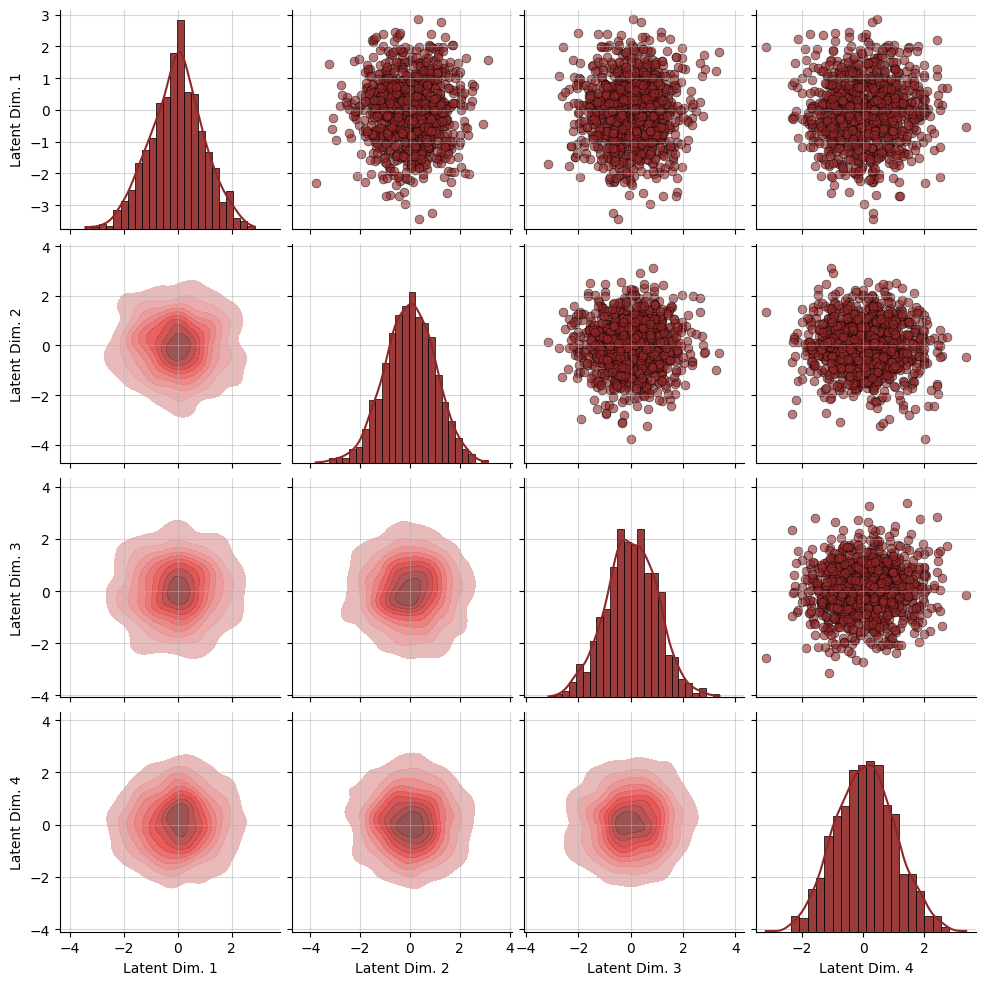

In [8]:
f = bf.diagnostics.plot_latent_space_2d(z)

## Calibration (unconstrained space)

In [9]:
prior_samples = df['parameters']
posterior_samples = amortizer.sample(df, n_samples=1000)

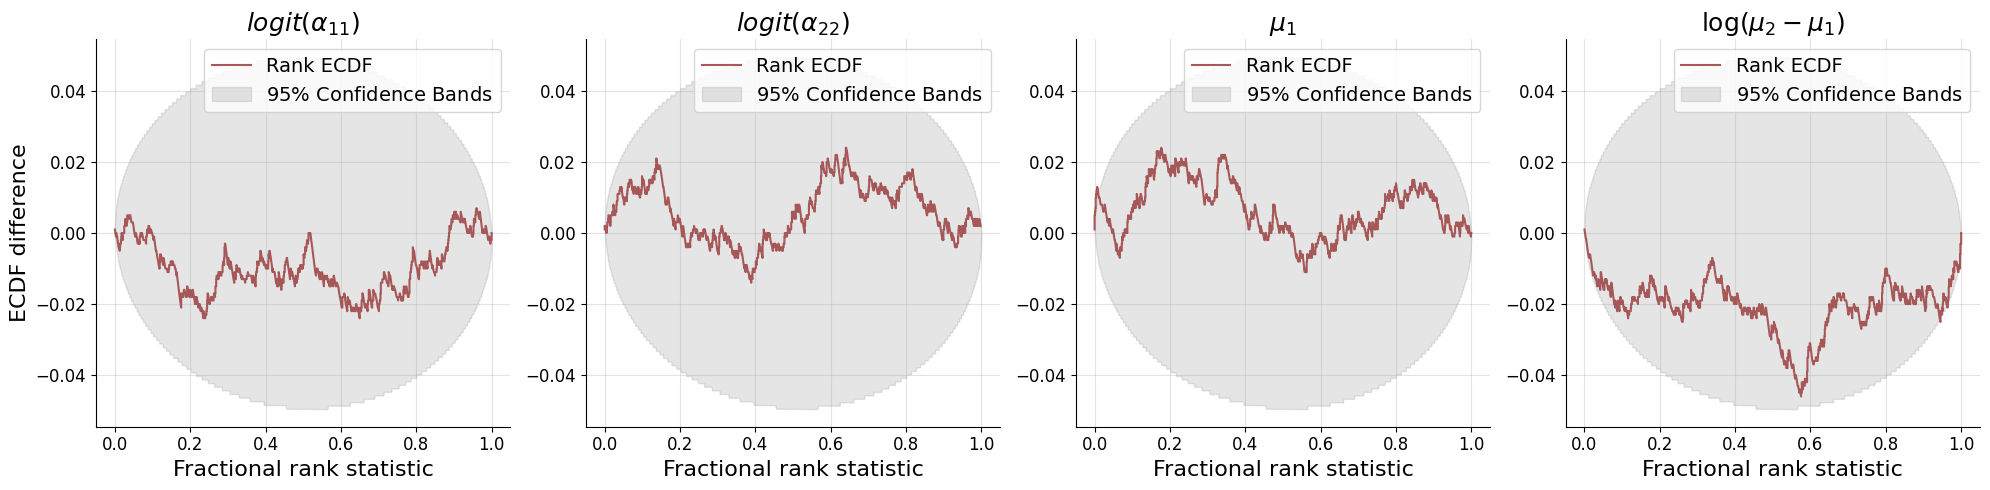

In [10]:
f = bf.diagnostics.plot_sbc_ecdf(posterior_samples, prior_samples, difference=True, param_names=model.param_names)

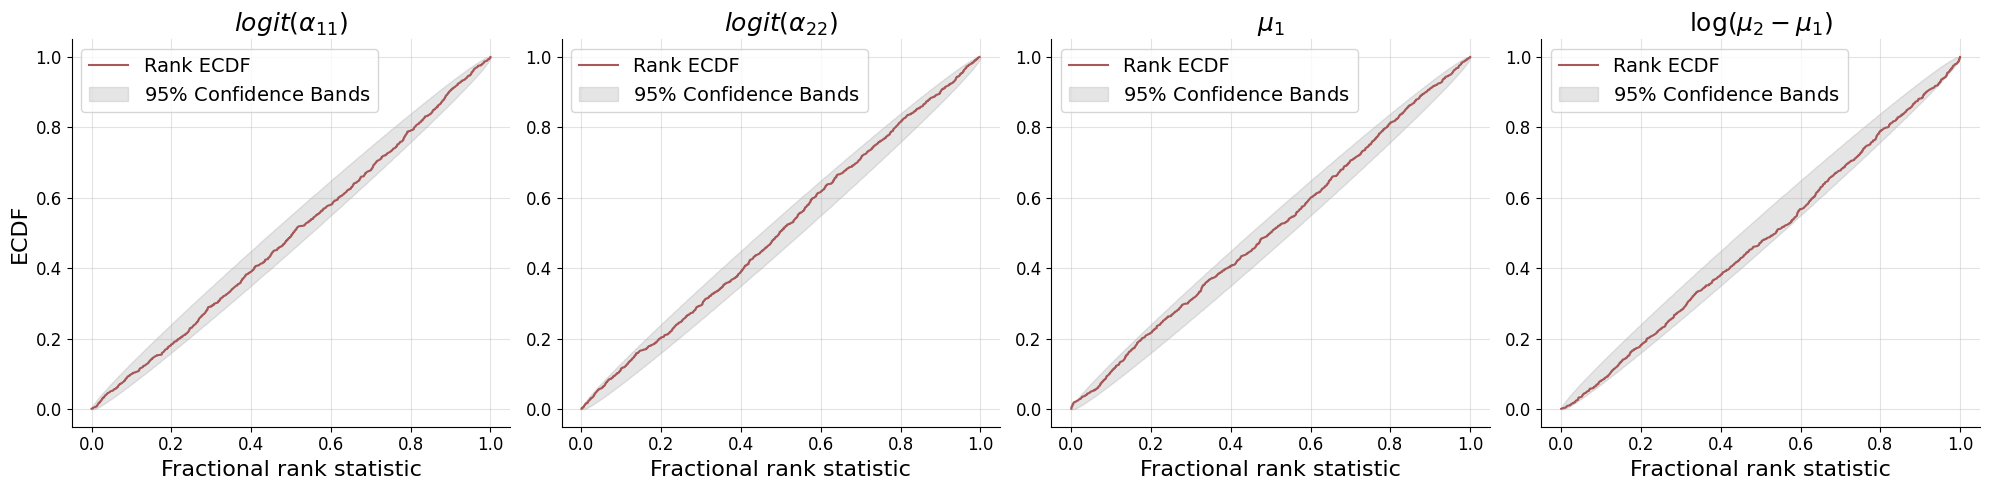

In [11]:
f = bf.diagnostics.plot_sbc_ecdf(posterior_samples, prior_samples, param_names=model.param_names)

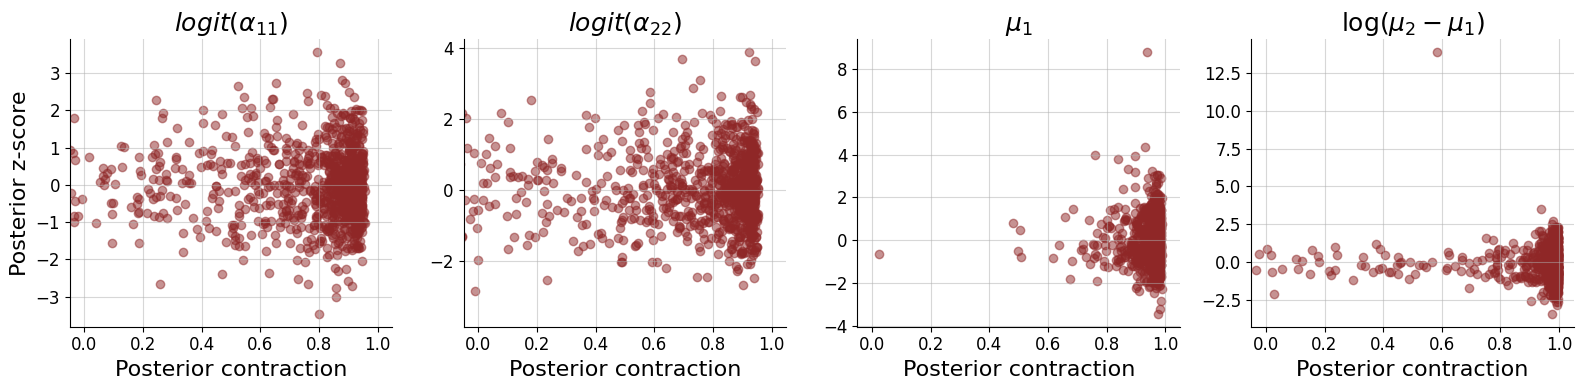

In [12]:
f = bf.diagnostics.plot_z_score_contraction(posterior_samples, prior_samples, param_names=model.param_names)

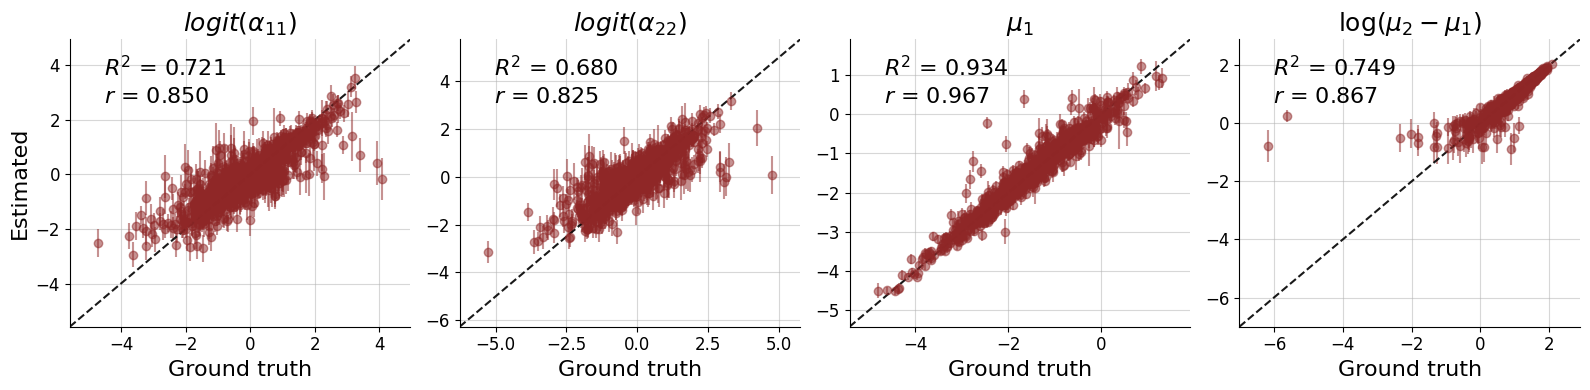

In [13]:
f = bf.diagnostics.plot_recovery(posterior_samples, prior_samples, param_names=model.param_names)

## Calibration (constrained space)

In [15]:
prior_samples = constrain_parameters(prior_samples)
posterior_samples = constrain_parameters(posterior_samples)

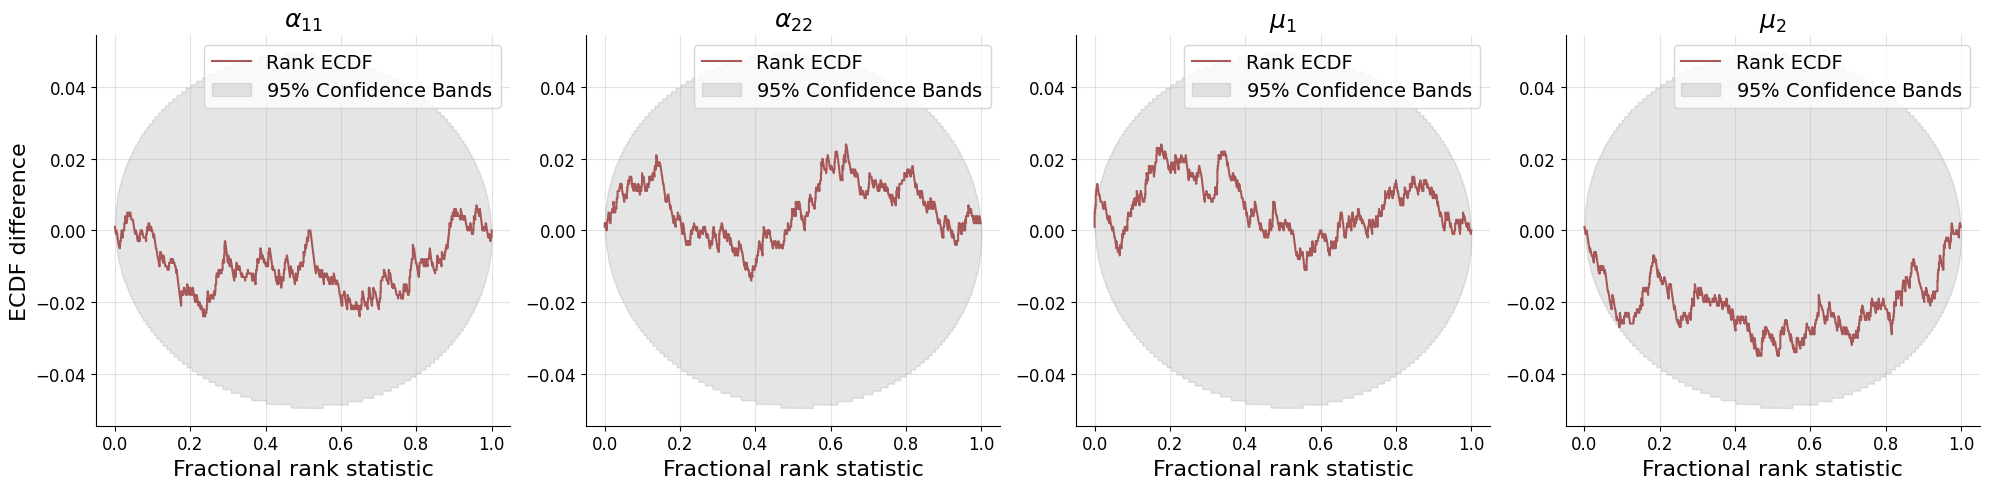

In [16]:
f = bf.diagnostics.plot_sbc_ecdf(posterior_samples, prior_samples, difference=True, param_names=constrained_parameter_names)

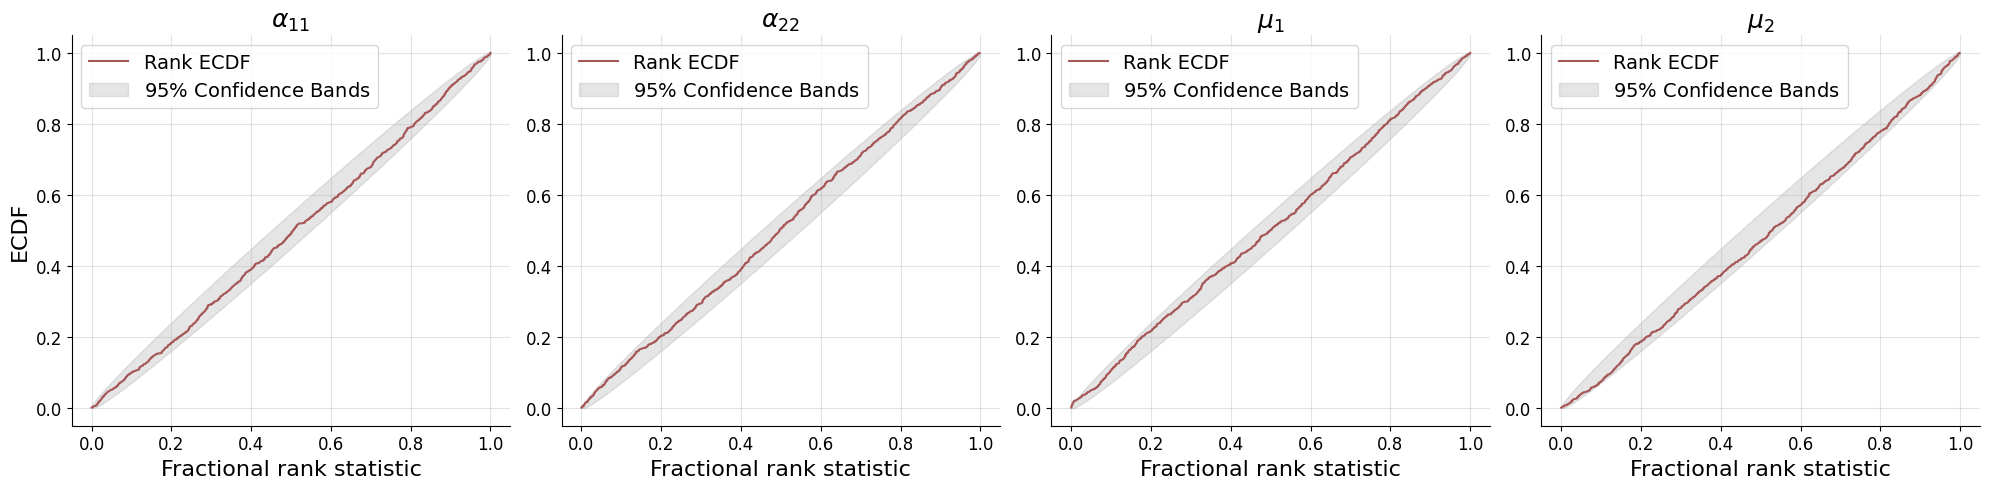

In [17]:
f = bf.diagnostics.plot_sbc_ecdf(posterior_samples, prior_samples, param_names=constrained_parameter_names)

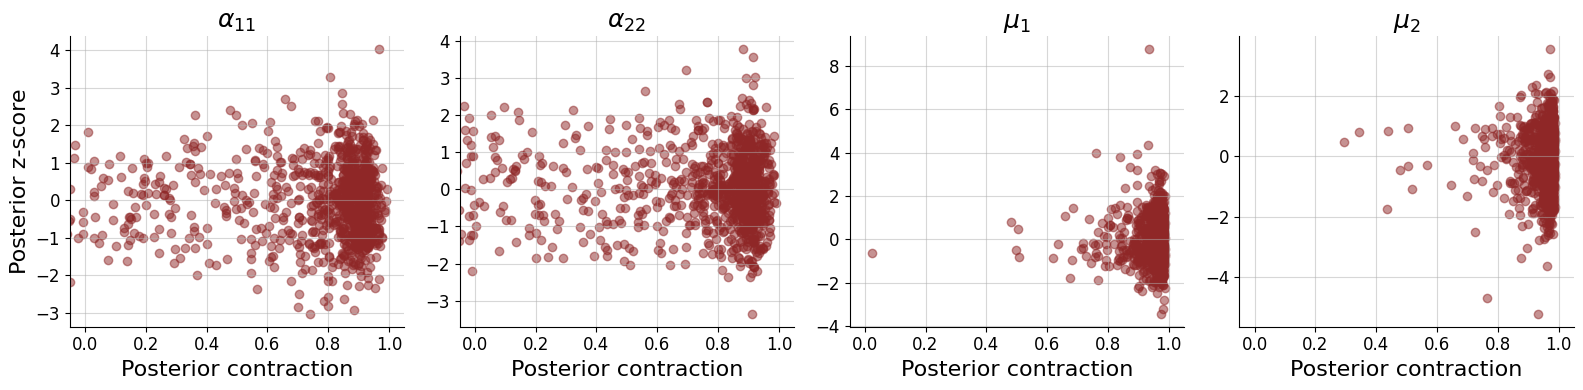

In [18]:
f = bf.diagnostics.plot_z_score_contraction(posterior_samples, prior_samples, param_names=constrained_parameter_names)

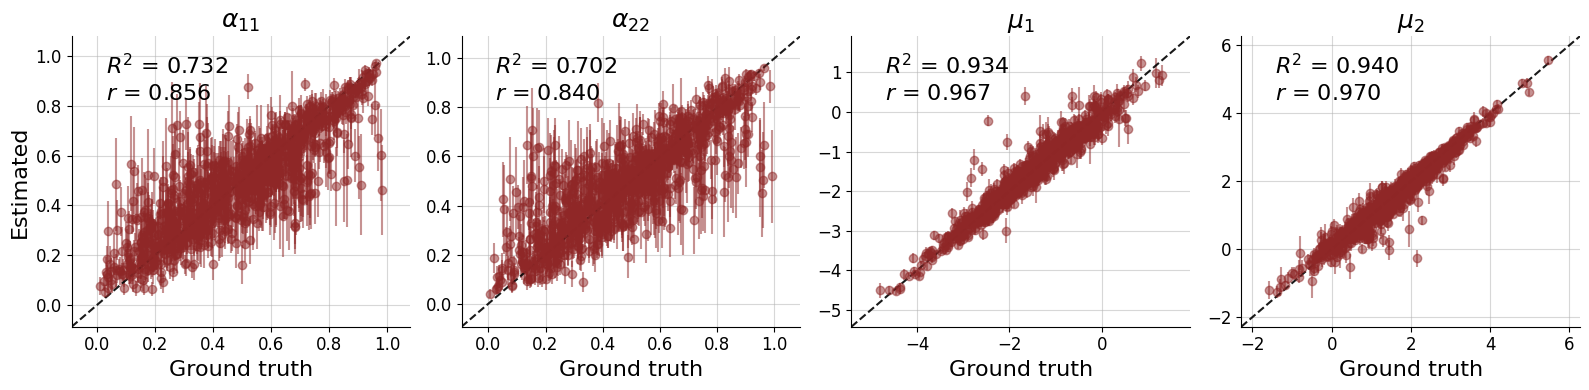

In [19]:
f = bf.diagnostics.plot_recovery(posterior_samples, prior_samples, param_names=constrained_parameter_names)